## 공용 코드

In [2]:
import sys

# sklearn ≥0.20 필수
import sklearn

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(21)

# 깔끔한 그래프 출력을 위해
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import platform
from matplotlib import font_manager, rc

# 매킨토시의 경우
if platform.system() == 'Darwin':
  rc('font', family='AppleGothic')
# 윈도우의 경우
elif platform.system() == 'Windows':
  font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
  rc('font', family=font_name)
  mpl.rcParams['axes.unicode_minus'] = False

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.13.0


## 선형 회귀

In [4]:
# 입력의 차원이 1개인 단순 선형 회귀

X = np.arange(1, 6)
y = X * 3 + 2

# 모델 생성
# input data의 차원이 1 이므로 input_shape 도 1
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape = [1])
])

In [5]:
# 모델의 구조 확인

# 출력(output)이 1개이므로 회귀
# layer 에는 bias 가 추가되므로 parameter 수는 2개
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# 모델을 컴파일

'''
model.compile(optimizer = 'sgd', loss = 'mean_squared_error',
              metrics = ['mean_squared_error', 'mean_absolute_error'])
'''
# 위와 동일한 모델이지만 축약해서 작성
model.compile(optimizer = 'sgd', loss = 'mse',
              metrics = ['mse', 'mae'])

# 매개변수를 인스턴스나 함수, 변수로 설정할 수 있음
# 아래에서는 인스턴스로 입력했지만 역시 동일한 모델
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.05),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.losses.MeanSquaredError(),
                         tf.keras.losses.MeanAbsoluteError()])

In [ ]:
# 모델 훈련

# 훈련을 위해 fit 함수를 사용
# 훈련 정보를 확인하기 위해 변수에 할당
# 모델을 만들 때 설정한대로 loss, MSE, MAE 를 출력함
# verbose = 0 을 설정하면 훈련 과정을 출력하지 않음
history = model.fit(X, y, epochs = 2000)

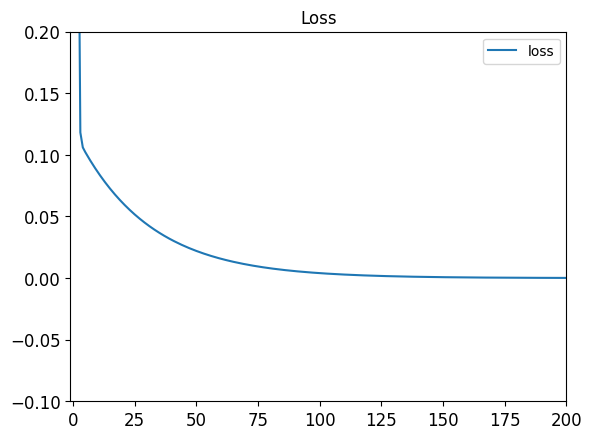

In [15]:
# 훈련 과정에서 발생하는 손실 값과 평가 지표 시각화

# fit 의 결과를 반환한 변수 안의 history 에 정보가 들어있음
plt.plot(history.history['loss'], label = 'loss')
#plt.plot(history.history['mae'], label = 'mae')
plt.xlim(-1, 200)
plt.ylim(-0.1, 0.2)
plt.title('Loss')
plt.legend()
plt.show()


In [16]:
# 결과 검증
model.evaluate(X, y)

1/1 [==============================] - 1s 749ms/step - loss: 3.0923e-12 - mean_squared_error: 3.0923e-12 - mean_absolute_error: 1.3351e-06


[3.09228207276413e-12, 3.09228207276413e-12, 1.3351440202313825e-06]

In [19]:
# 기존 y 는 3 * X + 2
model.predict([10]) # 32 -> 32.000008
model.predict([6]) # 20 -> 20.000004

1/1 [==============================] - 0s 63ms/step


array([[32.000008]], dtype=float32)

## 분류

### 화이트 와인과 레드 와인 이항 분류

In [23]:
# 데이터 가져오기

import pandas as pd
red = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
white = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

print(red.head())
print(white.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [24]:
# 데이터에 타겟 생성
red['type'] = 0
white['type'] = 1

# 2개의 서로 다른 데이터를 세로 방향으로 합치기 - concat
wine = pd.concat([red, white])
print(wine.describe())
# describe 의 type 을 보면 0과 1이 존재하므로 합치기 성공

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

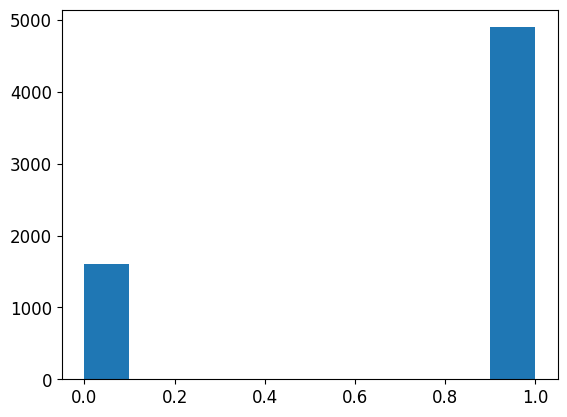

In [25]:
# 데이터에서 target(여기서는 type)의 분포를 확인
plt.hist(wine['type'])
plt.show()
# 그래프로 보면 약 3배정도 차이
# 보통 10배 이상 차이가 나면 조절이 필요하고 5배까지는 안정권

In [28]:
# 데이터의 정규화
# sklearn 의 MinMaxScaler 를 적용한 것과 같음
# 모든 컬럼에서 최소는 0, 최대는 1
wine_norm = (wine - wine.min()) / (wine.max() - wine.min())
print(wine_norm.head())
print(wine_norm.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.297521          0.413333     0.000000        0.019939   0.111296   
1       0.330579          0.533333     0.000000        0.030675   0.147841   
2       0.330579          0.453333     0.024096        0.026074   0.137874   
3       0.611570          0.133333     0.337349        0.019939   0.109635   
4       0.297521          0.413333     0.000000        0.019939   0.111296   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.034722              0.064516  0.206092  0.612403   0.191011   
1             0.083333              0.140553  0.186813  0.372093   0.258427   
2             0.048611              0.110599  0.190669  0.418605   0.241573   
3             0.055556              0.124424  0.209948  0.341085   0.202247   
4             0.034722              0.064516  0.206092  0.612403   0.191011   

    alcohol   quality  type  
0  0.202899  0.333333   0.

In [29]:
# 데이터 샘플링
# sample 은 랜덤하게 가져오는 기능을 하고 frac 은 비율
# frac 이 1이므로 전체 데이터에 대해 진행
wine_shuffle = wine_norm.sample(frac = 1)
print(wine_shuffle.head())
# 이전과 다르게 type 을 보면 0과 1의 분포가 섞여있음

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
564        0.760331          0.260000     0.295181        0.056748   0.126246   
951        0.314050          0.093333     0.204819        0.139571   0.043189   
1312       0.347107          0.733333     0.126506        0.019939   0.122924   
2137       0.280992          0.053333     0.156627        0.099693   0.074751   
4343       0.165289          0.093333     0.150602        0.013804   0.024917   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
564              0.017361              0.094470  0.288992  0.449612   
951              0.086806              0.315668  0.181029  0.279070   
1312             0.045139              0.080645  0.158280  0.480620   
2137             0.138889              0.502304  0.182957  0.511628   
4343             0.069444              0.237327  0.100829  0.503876   

      sulphates   alcohol   quality  type  
564    0.258427  0.681159  0.500000   0.0 

In [31]:
# tensor 와의 호환을 위해 pandas 의 DataFrame 을 numpy 의 ndarray 로 변환
wine_array = wine_shuffle.values
# wine_array = wine_shuffle.to_numpy() # 동일 기능
print(wine_array[:6])

[[0.76033058 0.26       0.29518072 0.05674847 0.12624585 0.01736111
  0.09447005 0.28899171 0.4496124  0.25842697 0.68115942 0.5
  0.        ]
 [0.31404959 0.09333333 0.20481928 0.13957055 0.04318937 0.08680556
  0.3156682  0.1810295  0.27906977 0.15168539 0.26086957 0.5
  1.        ]
 [0.34710744 0.73333333 0.12650602 0.01993865 0.12292359 0.04513889
  0.08064516 0.15828032 0.48062016 0.14044944 0.36231884 0.33333333
  0.        ]
 [0.28099174 0.05333333 0.15662651 0.09969325 0.07475083 0.13888889
  0.50230415 0.18295739 0.51162791 0.18539326 0.30434783 0.33333333
  1.        ]
 [0.16528926 0.09333333 0.15060241 0.01380368 0.02491694 0.06944444
  0.23732719 0.100829   0.50387597 0.20224719 0.34782609 0.5
  1.        ]
 [0.27272727 0.23333333 0.25301205 0.07515337 0.1013289  0.09722222
  0.28341014 0.19645267 0.54263566 0.28089888 0.36231884 0.33333333
  0.        ]]


In [32]:
# 훈련에 사용할 데이터 생성

# 훈련 데이터로 전체의 80%를 사용
# 이미 섞여있는 데이터이므로 인덱스를 활용할 수 있음
train_idx = int(len(wine_array) * 0.8)

# train_idx 를 기준으로 행 단위로 분할
# 타겟인 맨 마지막 열은 y 데이터에 넣고 나머지는 X 데이터에 삽입해서 분리
X_train, y_train = wine_array[:train_idx, :-1], wine_array[:train_idx, -1]
X_test, y_test = wine_array[train_idx:, :-1], wine_array[train_idx:, -1]

# 레드 와 화이트 로 분류할 것이므로 타겟에 원 핫 인코딩 진행 - 이항 분류
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 2)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5197, 12) (1300, 12)
(5197, 2) (1300, 2)


In [46]:
# 분류 모델

# 중간 층의 수, 유닛의 수, 활성 함수 등은 어떻게 조절해도 괜찮지만
# 첫번째 층의 input_shape 와 마지막 출력 층의 units 는 반드시 정해진 값으로
# 데이터의 컬럼이 12개+1개(type)이므로 첫번째에서 input_shape 는 12이고
# 마지막 층의 units 는 분류의 결과인 2개(클래스의 수)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 128, activation = 'relu', input_shape = [12]),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 32, activation = 'relu'),
    tf.keras.layers.Dense(units = 12, activation = 'relu'),
    tf.keras.layers.Dense(units = 2, activation = 'softmax')
])

# 최적화 함수는 Adam 을 사용하고 학습률은 0.05
# 손실 함수는 카테고리 크로스 엔트로프
# 평가 지표는 MSE, MAE
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy',
                         tf.keras.losses.MeanSquaredError(),
                         ])

# 모델의 구조 확인
model.summary()

# 훈련
history = model.fit(X_train, y_train, epochs = 25)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               1664      
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 12)                396       
                                                                 
 dense_39 (Dense)            (None, 2)                 26        
                                                                 
Total params: 12422 (48.52 KB)
Trainable params: 12422 (48.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
163/163

In [ ]:
# 훈련 - 검증 방식을 추가

# validation_split 을 설정하면 그 비율만큼을
# 검증 데이터로 사용하여 validation 을 수행
# 훈련 데이터에 validation 에 대한 평가 지표도 함께 출력
history = model.fit(X_train, y_train, epochs = 30,
                    validation_split = 0.25)

In [48]:
# 훈련 - batch size 를 조절

# batch_size 는 데이터를 분할해서 학습을 수행
# batch_size 를 사용할 수 있기 때문에 일부 데이터만 가지고 학습이 가능
# 그래서 훈련된 모델에 일부 데이터가 추가되는 경우 이어서 학습이 가능
history = model.fit(X_train, y_train, epochs = 30,
                    validation_split = 0.2, batch_size = 64)

Epoch 1/30
65/65 [==============================] - 0s 4ms/step - loss: 0.0430 - accuracy: 0.9923 - mean_squared_error: 0.0070 - val_loss: 0.0386 - val_accuracy: 0.9913 - val_mean_squared_error: 0.0075
Epoch 2/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9916 - mean_squared_error: 0.0074 - val_loss: 0.0522 - val_accuracy: 0.9913 - val_mean_squared_error: 0.0078
Epoch 3/30
65/65 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.9921 - mean_squared_error: 0.0069 - val_loss: 0.0368 - val_accuracy: 0.9913 - val_mean_squared_error: 0.0075
Epoch 4/30
65/65 [==============================] - 0s 4ms/step - loss: 0.0279 - accuracy: 0.9923 - mean_squared_error: 0.0060 - val_loss: 0.0386 - val_accuracy: 0.9913 - val_mean_squared_error: 0.0077
Epoch 5/30
65/65 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 0.9923 - mean_squared_error: 0.0058 - val_loss: 0.0375 - val_accuracy: 0.9913 - val_mean_squared_erro

In [49]:
model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9900 - mean_squared_error: 0.0127


[0.059117648750543594, 0.9900000095367432, 0.012693065218627453]

## 품질을 3가지로 나눠서 분류 - 다항 분류

In [51]:
# 품질 데이터 확인

print(wine['quality'].describe())
print(wine['quality'].value_counts())

# quality 를 기준으로 3 ~ 5 를 0, 6 을 1, 7 ~ 9 를 2 로 그룹화

count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


In [53]:
# 타겟 생성
wine.loc[wine['quality'] <= 5, 'new_quality'] = 0
wine.loc[wine['quality'] == 6, 'new_quality'] = 1
wine.loc[wine['quality'] >= 7, 'new_quality'] = 2

print(wine[['quality', 'new_quality']].head())

   quality  new_quality
0        5          0.0
1        5          0.0
2        5          0.0
3        6          1.0
4        5          0.0


In [55]:
# 피처에 대해 정규화 수행

# 이제 필요 없는 quality 컬럼 삭제
#del wine['quality']

# 데이터의 복사본 생성
wine_backup = wine.copy()

# 전체에 대해 정규화 수행
wine_norm = (wine - wine.min()) / (wine.max() - wine.min())

# 복사본에서 데이터 가져오기 - 타겟을 복원
wine_norm['new_quality'] = wine_backup['new_quality']

print(wine_norm.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.297521          0.413333     0.000000        0.019939   0.111296   
1       0.330579          0.533333     0.000000        0.030675   0.147841   
2       0.330579          0.453333     0.024096        0.026074   0.137874   
3       0.611570          0.133333     0.337349        0.019939   0.109635   
4       0.297521          0.413333     0.000000        0.019939   0.111296   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.034722              0.064516  0.206092  0.612403   0.191011   
1             0.083333              0.140553  0.186813  0.372093   0.258427   
2             0.048611              0.110599  0.190669  0.418605   0.241573   
3             0.055556              0.124424  0.209948  0.341085   0.202247   
4             0.034722              0.064516  0.206092  0.612403   0.191011   

    alcohol  type  new_quality  
0  0.202899   0.0      

In [57]:
# 훈련 데이터와 테스트 데이터를 분할

wine_shuffle = wine_norm.sample(frac = 1)
wine_array = wine_shuffle.to_numpy()

train_idx = int(len(wine_array) * 0.8)

X_train, y_train = wine_array[:train_idx, :-1], wine_array[:train_idx, -1]
X_test, y_test = wine_array[train_idx:, :-1], wine_array[train_idx:, -1]


# 타겟에 대해 원 핫 인코딩

# 이전과 다르게 이번에는 클래스가 3개 - 0, 1, 2 3개 그룹
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 3)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5197, 12) (1300, 12)
(5197, 3) (1300, 3)


In [64]:
# 모델 생성

# 이전 모델을 가져와서 수정
# input_shape 는 하나를 증가시키고 하나를 삭제해서 12로 동일
# 클래스가 3개이므로 출력 층의 units 도 3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 256, activation = 'relu', input_shape = [12]),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 32, activation = 'relu'),
    tf.keras.layers.Dense(units = 16, activation = 'relu'),
    tf.keras.layers.Dense(units = 8, activation = 'relu'),
    tf.keras.layers.Dense(units = 3, activation = 'softmax')
])

# 모델 컴파일
# 분류의 경우 loss 로 categorical_crossentropy 를 주로 사용
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', 'mse'])

history = model.fit(X_train, y_train, epochs = 50,
                    batch_size = 64, validation_split = 0.2)

Epoch 1/50
65/65 [==============================] - 3s 10ms/step - loss: 0.9700 - accuracy: 0.4994 - mse: 0.1977 - val_loss: 0.9409 - val_accuracy: 0.4558 - val_mse: 0.1958
Epoch 2/50
65/65 [==============================] - 0s 6ms/step - loss: 0.9108 - accuracy: 0.5263 - mse: 0.1869 - val_loss: 0.8872 - val_accuracy: 0.5567 - val_mse: 0.1821
Epoch 3/50
65/65 [==============================] - 0s 6ms/step - loss: 0.9104 - accuracy: 0.5357 - mse: 0.1865 - val_loss: 0.8847 - val_accuracy: 0.5856 - val_mse: 0.1812
Epoch 4/50
65/65 [==============================] - 0s 6ms/step - loss: 0.8845 - accuracy: 0.5487 - mse: 0.1818 - val_loss: 0.8955 - val_accuracy: 0.5567 - val_mse: 0.1805
Epoch 5/50
65/65 [==============================] - 0s 6ms/step - loss: 0.8810 - accuracy: 0.5521 - mse: 0.1813 - val_loss: 0.8595 - val_accuracy: 0.5606 - val_mse: 0.1761
Epoch 6/50
65/65 [==============================] - 0s 6ms/step - loss: 0.8736 - accuracy: 0.5651 - mse: 0.1793 - val_loss: 0.8250 - val_ac

In [63]:
# 모델의 훈련 결과 평가
model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 3ms/step - loss: 0.8243 - accuracy: 0.6115 - mse: 0.1696


[0.8243230581283569, 0.6115384697914124, 0.16957682371139526]